# <div style="text-align: center">18.335/6.337 Final Project - The L-BFGS algorithm</div>
##  <div style="text-align: center">Large-Scale Problem (using Strong Wolfe Line-Search)</div>
### <div style="text-align: center">Created by Yusu Liu and Simon Batzner</div>

## Import test functions and set up environment

In [37]:
function lbfgs!(F, x0, maxIt, m, save_pos = 0, τgrad=1e-5, verbose = 0)
    #INPUT
    # F: function to be optimized
    # x0: initial guess
    # maxIt: maximum Iteration
    # m: last m input differences and gradient differences are stored
    # τgrad: tolerance for norm of the slope


    #OUTPUT
    #x1: optimized variable
    #f1: function value at x1
    #k iteration number
    n = size(x0, 1)
    pos = zeros(maxIt, n)
    k=0
    n=length(x0)
    Sm=zeros(n,m) #S_k=x_k+1-x_k
    Ym=zeros(n,m) #Y_k=g_k+1-g_k

    f0,g0=F(x0)
    #use the simplest line search to find step size
    α, f1, g1=strongwolfe(F,-g0,x0,f0,g0)
    x1 = x0 - α.*g0
    k=1
    if save_pos == 1
        pos[1, :] = x0
        pos[2, :] = x1
    end

    while true
       if k>maxIt
           break
       end
       gnorm=norm(g0)
       if gnorm < τgrad
           break
       end
       s0=x1-x0
       y0=g1-g0
       #println("y0=$y0")

       H0=s0'*y0/(y0'*y0) #hessian diagonal satisfying secant condition
       # println(H0)
       # if H0<0
       #     H0=1
       # end
       # println(H0)
       #update Sm and Ym
       if k<=m
           Sm[:,k]=s0
           Ym[:,k]=y0
           p=-approxInvHess(g1,Sm[:,1:k],Ym[:,1:k],H0)
       # only keep m entries in Sm and Ym so purge the old ones
       elseif (k>m)
           Sm[:,1:(m-1)]=Sm[:,2:m]
           Ym[:,1:(m-1)]=Sm[:,2:m]
           Sm[:,m]=s0
           Ym[:,m]=y0
           p=-approxInvHess(g1,Sm,Ym,H0)
       end
       # new direction=p, find new step size
       α, fs, gs=strongwolfe(F,p,x1,f1,g1)
       #update for next iteration
       x0=x1
       g0=g1
       x1=x1+α.*p
       pos[k+1, :] = x1
       f1=fs
       g1=gs
       k=k+1

       if verbose == 1
           println("It=$k,x=$x1")
        end
    end

    k=k-1
    if save_pos == 1
        return x1, f1, k, pos
    else 
        return x1, f1, k
    end
end

lbfgs! (generic function with 4 methods)

In [38]:
function strongwolfe(F,d,x0,fx0,gx0,maxIt=100)
   α_m=20
   α_p=0
   c1=1e-4
   c2=0.9
   α_x=1
   gx0=copy(gx0'*d)
   fxp=copy(fx0)
   gxp=copy(gx0)
   i=1
   α_s=0
   fs=copy(fx0)
   gs=copy(gx0)
   while true
       xx=x0+α_x*d
       fxx,gxx=F(xx)
       fs=copy(fxx)
       gs=copy(gxx)
       gxx=copy(gxx'*d)

       if (fxx>(fx0+c1*α_x*gx0)[1]) || (i>1) & (fxx>=fxp)
           α_s,fs,gs=zoom(F,x0,d,α_p,α_x,fx0,gx0)
           return α_s,fs,gs
       end
       if abs(gxx)<=-c2*(gx0)
           α_s=copy(α_x)
           return α_s,fs,gs
       end
       if gxx>=0
       #if abs.(gxx)[1]>=0 && abs.(gxx)[2]>=0
           α_s,fs,gs=zoom(F,x0,d,α_x,α_p,fx0,gx0)
           return α_s,fs,gs
       end
       α_p=copy(α_x)
       fxp=copy(fxx)
       gxp=copy(gxx)

       if i>maxIt
           α_s=α_x
           return α_s,fs,gs

       end
       r=0.8
       #r=0.8
       α_x=α_x+(α_m-α_x)*r
       i=i+1

   end
   return α_s,fs,gs
end

strongwolfe (generic function with 2 methods)

In [39]:
function zoom(F,x0,d,α_l,α_h,fx0,gx0,maxIt=10)
   c1=1e-4
   c2=0.9
   i=0
   α_s=0
   fs=copy(fx0)
   gs=copy(gx0)
   while true
       α_x=0.5*(α_l+α_h)
       α_s=copy(α_x)
       xx=x0+α_x*d
       fxx,gxx=F(xx)
       fs=copy(fxx)
       gs=copy(gxx)
       gxx=gxx'*d
       xl=x0+α_l*d
       fxl,gxl=F(xl)
       if (fxx>(fx0+c1*α_x*gx0)[1]) || fxx>=fxl
           α_h=copy(α_x)
       else
           if abs(gxx)[1]<=-c2*(gx0)
               α_s=copy(α_x)
               return α_s,fs,gs
           end
           if gxx*(α_h-α_l)[1]>=0
               α_h=copy(α_l)
           end
           α_l=copy(α_x)
       end
       i=i+1
       if i>maxIt
           α_s=copy(α_x)
           return α_s,fs,gs
       end
   end

   return α_s,fs,gs
end

zoom (generic function with 2 methods)

In [40]:
function approxInvHess(g,S,Y,H0,n=2)
    #INPUT

    #g: gradient nx1 vector
    #S: nxk matrixs storing S[i]=x[i+1]-x[i]
    #Y: nxk matrixs storing Y[i]=g[i+1]-g[i]
    #H0: initial hessian diagnol scalar

    #OUTPUT
    # p:  the approximate inverse hessian multiplied by the gradient g
    #     which is the new direction
    #notation follows:
    #https://en.wikipedia.org/wiki/Limited-memory_BFGS

    n,k=size(S)
    rho=zeros(k)
    for i=1:k
        rho[i].=abs(1/(Y[:,i]'*S[:,i]))
    end


    q=zeros(n,k+1)
    r=zeros(n,1)
    α=zeros(k,1)
    β=zeros(k,1)

    q[:,k+1]=g

    for i=k:-1:1
        α[i].=rho[i]*S[:,i]'*q[:,i+1]
        q[:,i].=q[:,i+1]-α[i]*Y[:,i]
    end

    z=zeros(n)
    z.=H0*q[:,1]


    for i=1:k
        β[i].=rho[i]*Y[:,i]'*z
        z.=z+S[:,i]*(α[i]-β[i])
    end

    p=copy(z)

    return p
end

approxInvHess (generic function with 2 methods)

## First Test

In [51]:
include("engvall.jl")
n = 1000
x0 = rand(n); 
tol = 1

if n === 1000
    x1, f1, k =lbfgs!(engvall_1000, x0, 1000, m); 
    
    if norm(f1 - 1108) > tol
        println("Failed... for n = $n")
    end
    println("Final f was $f1")
elseif n === 5000
    x1, f1, k =lbfgs!(engvall_5000, x0, 1000, m); 
    
    if norm(f1 - 5548) > tol
        println("Failed... for n = $n")
    end
    println("Final f was $f1")
end
        

Final f was 1108.1947187850249


## Define Functions and intervals to scan over

In [20]:
function test_range(fun, step, tol, m, τgrad)
    
    x1_opt = [1.0, 1.0]
    a0 = -2.048
    a1 = 2.048
    b0 = -2.048
    b1 = 2.048
    println("Scanning from $(a0) to $(a1) and from $(b0) to $(b1) for $(fun) function...")

    cnt = 0
    n = 0
    
    for a in a0:step:a1
        for b in b0:step:b1
            
            n += 1 
            x0 = [a, b]
            x1, f1, k = lbfgs!(fun, x0, 100, m, τgrad); 
        
            if (norm(x1 - x1_opt)) < tol
                break;
            else
                println("======\nfailed for: x0 = [$a, $b]")
                println("x1 found was: $(x1)\n")
                cnt += 1
            end
        end
    end
    
    println("\nFailed $(cnt) out of $n tests...")
end

test_range (generic function with 1 method)

## Scan over range

In [24]:
x1_opt = [1.0, 1.0]
step = 0.1
tol = 1e-3  # note that this is the tol to check the optimal solution vs the found solution, not the tol for lbfgs
τgrad = 1e-10
m = 2
println("M: $m, τgrad = $(τgrad):\n")
test_range(engvall_1000, step, tol, m, τgrad)

M: 2, τgrad = 1.0e-10:

Scanning from -10 to 10 and from -10 to 10 for booth function...

Failed 0 out of 201 tests...


# Benchmarking

## Timing

In [180]:
maxIt = 100
m = 2
tol = 1e-6
verbose = 0
range = 1000

funs = [rosenbrock, himmelblau, booth, bohachevsky1, easom]

for fun in funs
    t = 0.0
    
    for i in 1:range
        x0 = [rand(-1:0.1:1), rand(-1:0.1:1)]
        t += @elapsed lbfgs!(fun, x0, maxIt, m, tol, verbose)
    end
    
    println("\nTime elapsed for $(range) evaluations of $(fun): $t")
end


Time elapsed for 1000 evaluations of rosenbrock: 1.0438719779999999

Time elapsed for 1000 evaluations of himmelblau: 0.7894598900000009

Time elapsed for 1000 evaluations of booth: 0.6849826409999998

Time elapsed for 1000 evaluations of bohachevsky1: 1.0825619500000008

Time elapsed for 1000 evaluations of easom: 0.8356510089999989


## Memory

In [181]:
mem = @allocated lbfgs!(rosenbrock, x0, 10, 2, 1e-6, 0)
println("Number of bytes allocated: $(mem)")

Number of bytes allocated: 102976


In [182]:
@time lbfgs!(rosenbrock, x0, 10, 2, 1e-6, 0)

  0.001027 seconds (1.98 k allocations: 100.719 KiB)


([0.999927, 0.999894], 1.704460746826816e-7, 10)

## Profiling

In [183]:
Profile.init()
lbfgs!(himmelblau, x0, 10, 2, 1e-6, 0)
@profile lbfgs!(rosenbrock, x0, 10, 2, 1e-6, 0)

([0.999927, 0.999894], 1.704460746826816e-7, 10)

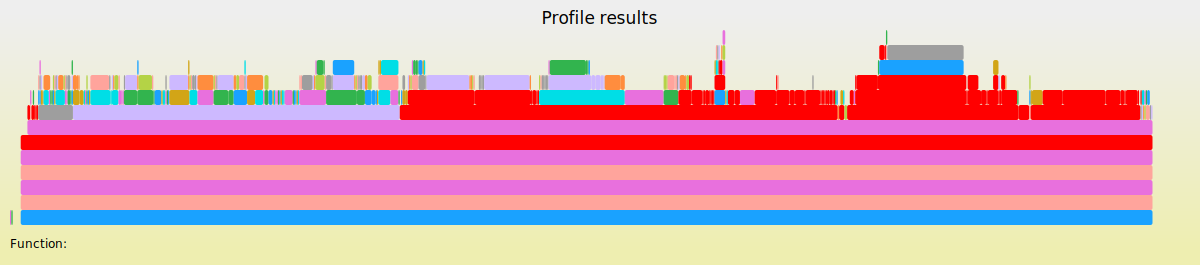

In [184]:
# Pkg.add("ProfileView")
using ProfileView
ProfileView.view()

In [185]:
Profile.print()

1   ./array.jl:0; _collect(::Array{Float64,1}, ::Ba...
1   ./arraymath.jl:0; +(::Array{Float64,1}, ::Array{Flo...
845 ./task.jl:335; (::IJulia.##14#17)()
 845 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  845 ...rc/execute_request.jl:154; execute_request(::ZMQ.Socket, ::...
   845 .../Compat/src/Compat.jl:174; include_string(::Module, ::Strin...
    845 ./loading.jl:522; include_string(::String, ::String)
     845 ./In[167]:15; benchmark(::Int64, ::Function)
      845 ./profile.jl:23; macro expansion
       840 ./In[166]:4; loop_bfgs(::Int64, ::Function)
        2   ./In[149]:22; lbfgs!(::#rosenbrock, ::Array...
         2 ./broadcast.jl:455; broadcast
          1 ./broadcast.jl:312; broadcast_c
           1 ./inference.jl:5401; return_type(::Any, ::Any)
            1 ./reflection.jl:502; _methods(::ANY, ::ANY, ::In...
          1 ./broadcast.jl:316; broadcast_c
           1 ./broadcast.jl:0; broadcast_t(::Function, ::Typ...
        2   ./In[149]:30; lbfgs!(::#rosenbrock, ::Ar

             1  ...nalg/rowvector.jl:147; to_vecs
              1 ./tuple.jl:159; map
               1 ...nalg/rowvector.jl:145; to_vec
           1  ./linalg/blas.jl:309; dot(::Array{Float64,1}, ::A...
           3  ./linalg/blas.jl:313; dot(::Array{Float64,1}, ::A...
         41 ./In[152]:34; approxInvHess(::Array{Float64...
          19 ./abstractarray.jl:883; getindex
           19 ./multidimensional.jl:491; _getindex
            19 ...ltidimensional.jl:495; macro expansion
             1  ...ltidimensional.jl:0; _unsafe_getindex(::IndexLi...
             14 ...ltidimensional.jl:506; _unsafe_getindex(::IndexLi...
              1  ...ltidimensional.jl:509; macro expansion
              12 ...ltidimensional.jl:511; macro expansion
              1  ...ltidimensional.jl:513; macro expansion
               1 ...ltidimensional.jl:519; _unsafe_getindex!
                1 ...tidimensional.jl:525; macro expansion
                 1 ./cartesian.jl:62; macro expansion
          15 ./arraymath

            1 ./arraymath.jl:45; *(::Int64, ::Array{Float64,1})
             1 ./broadcast.jl:455; broadcast
              1 ./broadcast.jl:316; broadcast_c
               1 ./broadcast.jl:268; broadcast_t
            1 ./arraymath.jl:38; +(::Array{Float64,1}, ::Arra...
           2 ./In[151]:17; zoom(::#rosenbrock, ::Array{F...
            2 ...GS-Julia/testfns.jl:6; rosenbrock(::Array{Float64,1})
             2 ./array.jl:76; vect(::Float64, ::Vararg{Fl...
         1  ./In[150]:25; strongwolfe(::#rosenbrock, ::...
         1  ./In[150]:27; strongwolfe(::#rosenbrock, ::...
         9  ./In[150]:34; strongwolfe(::#rosenbrock, ::...
         11 ./In[150]:40; strongwolfe(::#rosenbrock, ::...
         60 ./In[150]:45; strongwolfe(::#rosenbrock, ::...
          1 ./float.jl:0; +(::Float64, ::Float64)
          1 ./promotion.jl:0; -(::Int64, ::Float64)
          1 ./promotion.jl:251; -(::Int64, ::Float64)
         1  ./arraymath.jl:39; +(::Array{Float64,1}, ::Array...
        1   ./In[149]:

In [186]:
function loop_bfgs(range = 100, fun = rosenbrock)
    
    for i = 1:range
        lbfgs!(fun,x0,100,20)
    end
    
end

loop_bfgs (generic function with 3 methods)

In [187]:
# Reference: https://thirld.com/blog/2015/05/30/julia-profiling-cheat-sheet/

function benchmark(range = 100, fun = rosenbrock)
    seed = 42
    
    # force compilation
    srand(seed)
    @time lbfgs!(fun,x0,100,20)

    # profile
    srand(seed)
    Profile.init(delay=0.001)
    Profile.clear()
#     clear_malloc_data()
    @profile loop_bfgs(range, fun)

    # store output
    r = Profile.retrieve()
    f = open("profile.bin", "w")
    serialize(f, r)
    close(f)
end

benchmark (generic function with 3 methods)

  0.008412 seconds (195.53 k allocations: 7.882 MiB)


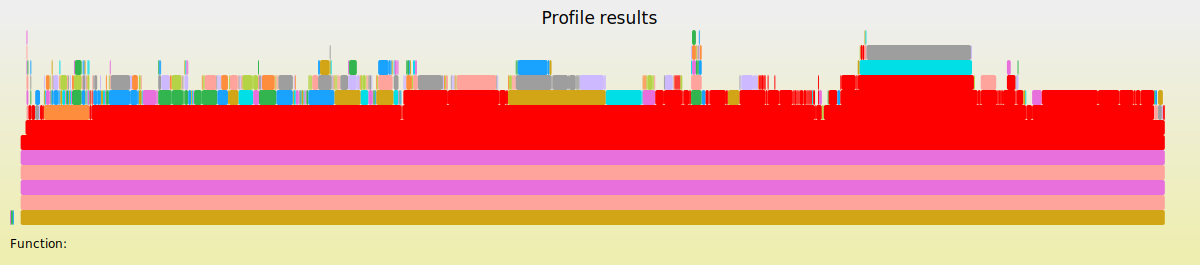

In [188]:
range = 100
fun = rosenbrock
benchmark(range, fun)

using ProfileView
f = open("profile.bin")
r = deserialize(f);
ProfileView.view(r[1], lidict=r[2])

In [189]:
x0 = [-1.948, -2.048]
include("testfns.jl")

x1, f1, k=lbfgs!(rosenbrock,x0,100,2)

([1.0, 1.0], 1.0523268890180213e-26, 35)